In [1]:
import os
os.chdir(os.getcwd())

In [2]:
#limit VRAM usage
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


2023-07-26 16:32:19.807454: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 16:32:20.352101: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-26 16:32:20.831970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 16:32:20.848457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [3]:
#check and remove dodgy images from dataset
import cv2
import imghdr

data_dir = 'data'
image_exts = ['jpg', 'jpeg', 'bmp', 'png']
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image extension not supported: ', format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image: ', format(image_path))

In [4]:
#creating a dataset using keras and all the images in the data folder
import numpy as np
from matplotlib import pyplot as plt
#building a data pipeline
data = tf.keras.utils.image_dataset_from_directory('data')

#scaling the data to be between 0 and 1 from 0 to 255
# logic - scaled = batch[0] / 255 but we apply this directly to the pipeline
data = data.map(lambda x, y: (x / 255, y)) # type: ignore

Found 47009 files belonging to 2 classes.


2023-07-26 16:32:43.060879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 16:32:43.061042: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 16:32:43.061145: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
#making it an interator to allow us to loop through the data
data_iterator = data.as_numpy_iterator() # type: ignore
#grab a batch of data
batch = data_iterator.next()
#batch[0].shape #shape of the images
batch[1] 
# Classification labels: 0 - Female, 1 - Male.

2023-07-26 16:32:43.497485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [47009]
	 [[{{node Placeholder/_4}}]]
2023-07-26 16:32:43.497705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [47009]
	 [[{{node Placeholder/_0}}]]


array([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0], dtype=int32)

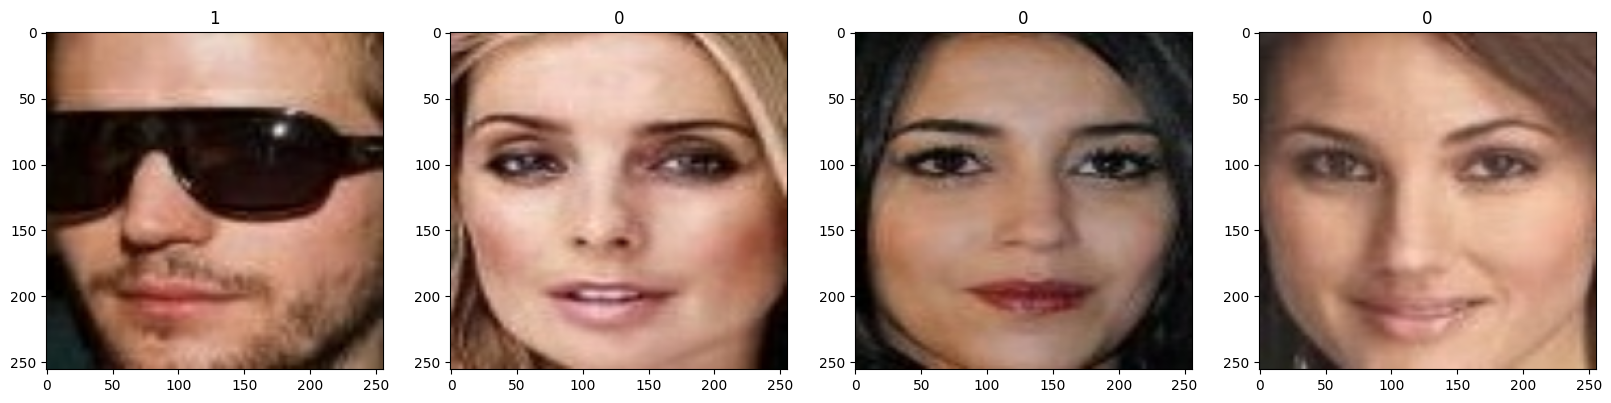

In [6]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    #ax[idx].imshow(img.astype(int))
    ax[idx].set_title(batch[1][idx])
    #ax[idx].title.set_text(batch[1][idx])

In [7]:
len(data)

1470

In [8]:
#making training, validation and test sets, they all add up to len(data) = 1470 in this case
train_size = int(0.7 * len(data))
val_size = int(0.2 * len(data))
test_size = int(0.1 * len(data))
train = data.take(train_size) # type: ignore
val = data.skip(train_size).take(val_size) # type: ignore
test = data.skip(train_size+val_size).take(test_size) # type: ignore

In [9]:
#building the model
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [10]:
#training the model
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40


2023-07-26 16:32:44.354520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [47009]
	 [[{{node Placeholder/_4}}]]
2023-07-26 16:32:44.354863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [47009]
	 [[{{node Placeholder/_4}}]]
2023-07-26 16:32:45.598379: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-26 16:32:46.186510: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-26 

1029/1029 [==============================] - ETA: 0s - loss: 0.2852 - accuracy: 0.8807

2023-07-26 16:33:03.159675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [47009]
	 [[{{node Placeholder/_4}}]]
2023-07-26 16:33:03.159928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [47009]
	 [[{{node Placeholder/_4}}]]


1029/1029 [==============================] - 27s 23ms/step - loss: 0.2852 - accuracy: 0.8807 - val_loss: 0.1962 - val_accuracy: 0.9209
Epoch 2/40
1029/1029 [==============================] - 23s 23ms/step - loss: 0.1688 - accuracy: 0.9356 - val_loss: 0.1724 - val_accuracy: 0.9354
Epoch 3/40
1029/1029 [==============================] - 23s 23ms/step - loss: 0.1242 - accuracy: 0.9551 - val_loss: 0.1767 - val_accuracy: 0.9418
Epoch 4/40
1029/1029 [==============================] - 24s 23ms/step - loss: 0.0935 - accuracy: 0.9657 - val_loss: 0.1963 - val_accuracy: 0.9410
Epoch 5/40
1029/1029 [==============================] - 24s 23ms/step - loss: 0.0637 - accuracy: 0.9780 - val_loss: 0.2185 - val_accuracy: 0.9455
Epoch 6/40
1029/1029 [==============================] - 24s 23ms/step - loss: 0.0418 - accuracy: 0.9858 - val_loss: 0.3056 - val_accuracy: 0.9310
Epoch 7/40
1029/1029 [==============================] - 23s 23ms/step - loss: 0.0298 - accuracy: 0.9898 - val_loss: 0.4199 - val_accura

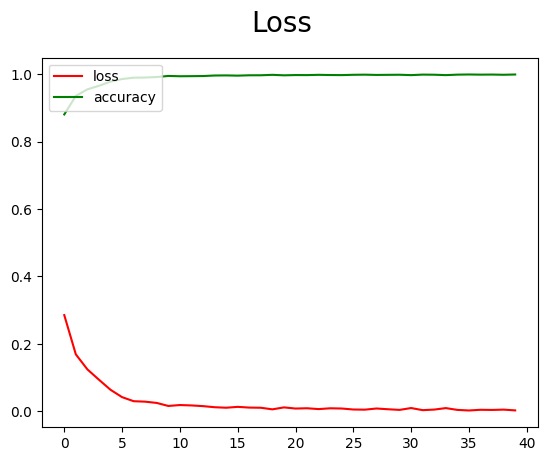

In [39]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='red', label='loss')
plt.plot(hist.history['accuracy'], color='green', label='accuracy')
#plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

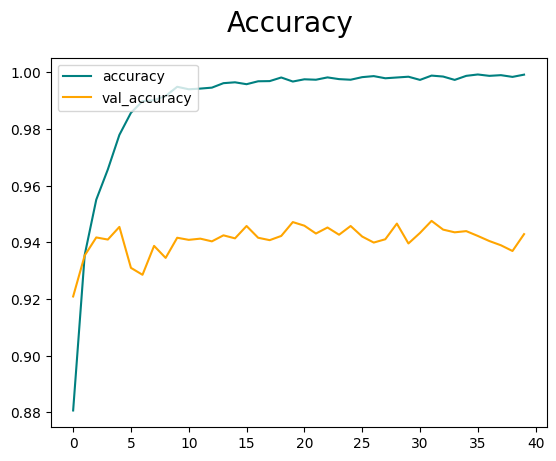

In [40]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [41]:
#Evaluate the model performance
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy # type: ignore
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
len(test)

147

In [42]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 12ms/step


In [43]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.9462227821350098, Recall: 0.9378172755241394, Accuracy: 0.941579282283783


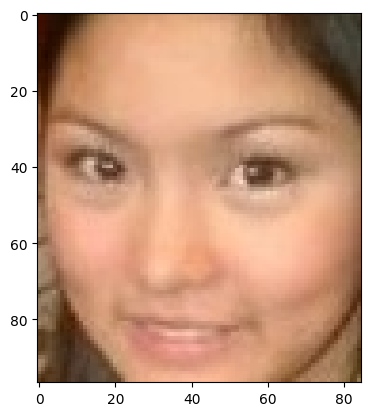

In [49]:
#Test the model
img = cv2.imread('ftest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

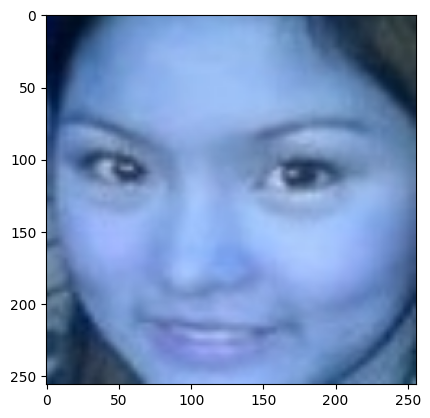

In [50]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int)) # type: ignore
plt.show()

In [51]:
np.expand_dims(resize, 0).shape
yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat)
if yhat>0.5:
    print('prediction: Male')
else:
    print('prediction: Female')

1/1 [==============================] - 0s 12ms/step
[[2.6891355e-11]]
prediction: Female


In [52]:
#Save the model for future use.
from tensorflow.keras.models import load_model
model.save(os.path.join('models','gender_classifier.h5'))

In [53]:
#Load the saved model
new_model = load_model(os.path.join('models','gender_classifier.h5'))
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))
if yhat>0.5:
    print('prediction: Male')
else:
    print('prediction: Female')

1/1 [==============================] - 0s 40ms/step
prediction: Female
